In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E
    b.E = E
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E
    b.E = E
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



In [134]:
r = DData(12, E=-3)
K = DData(3.5,E=-2)

In [135]:
M_140 = [0,7,16,30,44,52,45,42,46,45,47]
A_140 = [92,92,90,90,92,2,80,92,32,74,20]
M_70 = [0,8,11,18,25,29,32,34,33,35,38,32]
A_70 = [85,86,86,87,87,86,83,11,24,7,2,65]
M_80 = [0,10,22,31,34,34,35,35,39,35,68,54]
A_80 = [90,89,88,88,83,70,53,24,4,40,0,1]
M_90 = [0,10,20,30,35,36,36,37,38,40,50,60]
A_90 = [86,86,84,85,86,80,70,62,15,6,1,0]
M_102 = [0,15,25,35,37,39,39,42,50,60]
A_102 = [85,85,85,85,85,32,21,7,1,0]
M_120 = [0,15,26,41,42,43,44,46,50,60]
A_120 = [90,90,89,89,85,54,15,8,4,0]


In [136]:
def calc(Ms, As, M_min = 0, M_max = 350, label = ""):
    Ms = pd.Series(Ms)
    As = pd.Series(As)
    Ms = Ms*300/75
    As = As*0.6/150
    Ms_srez = Ms[Ms>M_min][Ms<M_max]
    As_srez = As[Ms>M_min][Ms<M_max]

    plt.figure()
    plt.grid(True)
    plt.xlabel("$I_m$, mA")
    plt.ylabel("$I_a$, mA")
    plt.plot(Ms_srez, As_srez, "o", label = label)
    plt.legend()


In [137]:
Us = []
Im = []


In [ ]:
calc(M_70, A_70, label="70 В")
plt.savefig("ImIa_70.png", dpi = 300)
calc(M_70, A_70, 110, 140)
Us.append(DData(70, 1))
Im.append(DData(128, 1, E = -3))


In [ ]:
calc(M_80, A_80, label="80 В")
plt.savefig("ImIa_80.png", dpi = 300)
calc(M_80, A_80, 110, 170)
Us.append(DData(80, 1))
Im.append(DData(137, 2, E = -3))

In [ ]:
calc(M_90, A_90, label="90 В")
plt.savefig("ImIa_90.png", dpi = 300)
calc(M_90, A_90, 110, 170)
Us.append(DData(90, 1))
Im.append(DData(150, 2, E = -3))

In [ ]:
calc(M_102, A_102, label="102 В")
plt.savefig("ImIa_102.png", dpi = 300)
calc(M_102, A_102, 110, 170)
Us.append(DData(102, 1))
Im.append(DData(152, 4, E = -3))

In [ ]:
calc(M_120, A_120, label="120 В")
plt.savefig("ImIa_120.png", dpi = 300)

calc(M_120, A_120, 150, 190)
Us.append(DData(120, 1))
Im.append(DData(173, 3, E = -3))

In [ ]:
calc(M_140, A_140, label="140 В")
plt.savefig("ImIa_140.png", dpi = 300)
calc(M_140, A_140, 150, 190)
Us.append(DData(140, 1))
Im.append(DData(182, 3, E = -3))

[18.01975 42.62755]
k, b = $3.28 \pm 0.24$ $4.2 \pm 7.3$
$1.82 \pm 0.14$


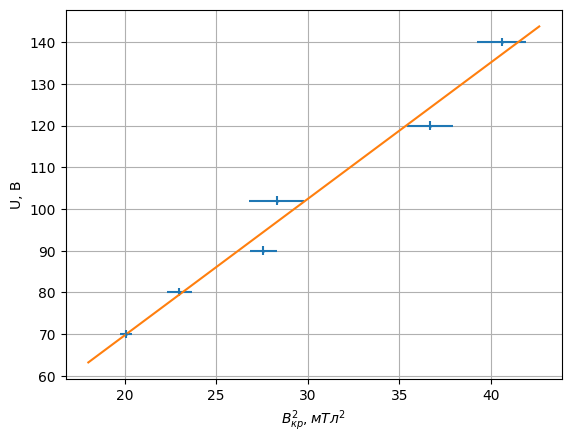

In [147]:
VIB = pd.DataFrame()
VIB["U, В"] = Us
VIB["I, mA"] = Im
VIB["B, мТл"] = 3.5/100 * VIB["I, mA"]
DData.changeEInSerias(VIB["B, мТл"], -3)
plt.xlabel("$B_{кр}^2, мТл^2$")
plt.ylabel("U, В")
k, _ = linearcalc_error(VIB["B, мТл"]**2, VIB["U, В"])
r = DData(12, 0.1, E = -3)
em = 8*k/r**2
em.E = 11
plt.savefig("UB.png", dpi = 300)
print(em)

In [145]:
raw_out = pd.DataFrame()
def add(V, M_v, A_v):
    M_v = list(M_v)
    A_v = list(A_v)
    for i in range(12- len(M_v)):
        M_v.append("")
        A_v.append("")
    raw_out[f"$I_M {V}$,дел"] = M_v
    raw_out[f"$I_A {V}$,дел"] = A_v
add(70, M_70, A_70)
add(80, M_80, A_80)
add(90, M_90, A_90)
add(102, M_102, A_102)
add(120, M_120, A_120)
raw_out.to_clipboard()

In [146]:
VIB.to_clipboard()